# 02-Fit of the intensity profiles for single stars

In this notebook, we demonstrate how to determine the line profile paramters that will be use to generate the synthetic Stokes V profile, base on a modelling of the Stokes I profiles. 

:::{note}
If you have already determined the parameters using your own tools, you can move to the next tutorial. However, as our line profiles are parametrized by $\log\kappa$ (the log of the ratio of the line opacity to the continuum opacity), you will need to convert your line depth -- an easy way would be to use the tools below to fit $\log\kappa$ only, keeping your values for e.g. $v\sin i$ fixed to your determined value. 
:::

:::{warning}
The fitting demonstrated below uses an analytical formulation for the intensity line profile. While the continnum limb darkening is included in the rotational convolution kernel, the line limb-darkening is not. Therefore there will be a slight difference in shape between the analytical synthetic line profile and the line profile computer by the numerical disk integration (see details at INSERT LINK)
:::

You will need to import the packages below

In [6]:
# Importing packages
import pyRaven as rav

import pandas as pd
#import itertools
from IPython.display import display
import matplotlib.pyplot as plt
import h5py as h5
import json
import numpy as np

In [7]:
# Packages imported just for the html rendering (cell not shown in rendering)

from myst_nb import glue

## 1. Opening the information spreadsheets, and loading the DataPacked created in the previous tutorial

For this example, we will again use the spreadsheets from the previous section of the tutorial (INSERT LINK HERE), that contains some informations about the stars in the sample, as well as the observations for eachs stars.  

In the cell below, we open the spreadsheets, and select the rows containing the information for the star HD 13745. (see the previous tutorials for some tips on how to used to functionality of Pandas to automate your processing with loops).

In [2]:
#sheet_id = "1fHcSEr-hUV-VQ1bH9DjDppJQvZ-K9PzX5DRjnpKPbUk"
#sheet_name = "Stars"
#url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
#df_stars = pd.read_csv(url)

#sheet_name = "Observations"
#url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
#df_obs = pd.read_csv(url)

# Star contains the row for HD 13745
#star = df_stars.loc[df_stars["StarName"]=='hd13745']

# selecting the rows in the observation dataframe where the star name matches
#obs = df_obs.loc[df_obs["StarName"]=='hd13745']

In the cell below, we load the DataPacket that we created in the previous tutorial

In [3]:
DataPacket = rav.data.read_packet('ExampleOutput/01-DataSetup/ExamplePacket.h5')

## 2. Creating a parameter dictionary for the intensity profile fitting

A lot of the main codes in pyRaven rely on a dictionary to pass the necessary parameters necessary for computations (see LINK for details). 

As a simple introduction here, we demonstrate two ways of creating these dictionaries (default parameter function, and direct dictionary creation), as well as how to write to file (and read back)in .json format. 

In the cell below, we use the `params.get_def_param_fitI()` function to return a typical dictionary suitable for a calculation of the intensity profile. 
We use the `pprint` method to do a pretty-print of the dictionary. 
We also illustrate quickly how to edit the value of a key in a dictionary. 

As you can see, `param` is a dictionary of sub-dictionaries (as explained ADD LINK). For the calculation of intensity profiles with the ADD FUNCTION function, we only need some elements in the `"general"` sub-dictionary (we would need additional sub-dictionaries if we were making Stokes V calculations, for example). 

In [8]:
# Get a dictionaty with the necessary keys and default values
param = rav.params.get_def_param_fitI()

print('Default values for analytical intensity line profile calculation:')
print(param)

# We can modify any values in the dictionary
param["general"]["vsini"]=40.0

print('Our modified dictionary')
print(param)

Default values for analytical intensity line profile calculation:
{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vmac": 5.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10,
    "res": 65000
  }
}
Our modified dictionary
{
  "general": {
    "lambda0": 5000,
    "vsini": 40.0,
    "vmac": 5.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10,
    "res": 65000
  }
}


In [5]:
## This cell is the same as above, just to glue the output
## to be used in a tab below. 

# Get a dictionaty with the necessary keys and default values
param = rav.params.get_def_param_fitI()
glue("param1",param)

# We can modify any values in the dictionary
param["general"]["vsini"]=40.0
glue("param2", param)

{'general': {'lambda0': 5000,
  'vsini': 50.0,
  'vmac': 5.0,
  'vdop': 10.0,
  'av': 0.05,
  'bnu': 1.5,
  'logkappa': 0.98,
  'ndop': 10,
  'res': 65000}}

{'general': {'lambda0': 5000,
  'vsini': 40.0,
  'vmac': 5.0,
  'vdop': 10.0,
  'av': 0.05,
  'bnu': 1.5,
  'logkappa': 0.98,
  'ndop': 10,
  'res': 65000}}

The cell below is a markdown cell to show two tabs with each containing the output of one of the print() above

<!-- This is a markdown cell to show two tabs with each containing the output of one of the print() above -->

::::{tab-set}

:::{tab-item} Default values:
```{glue:} param1
```
:::

:::{tab-item} Our modified params dictionary:
```{glue} param2
```
:::
::::

The markdown cell below is to show a dropdown box with an alternative method to create a params dictionary

<!-- this is a markdown cell to show a dropdown box with an alternative method to create a params dictionary -->

::::{admonition} Click to preview an alternative method to create a params dictionary. 
:class: note, dropdown

See LINK for a more detailed documentation and list of options

We first create the dictionary that contains the necessary keywords in the `"general"` sub-dictionary. As we only need this sub-dictionary for the intensity profile calculations below, we then create the main dictionary with only the 'general' sub-dictionary. We use the `params.parameters(dict)` class to create a `parameters` object (which is simply a regular dictionary with a few add-ons) so that we can use the `pprint()` method afterwards (but this is not strickly necessary to use the pyRaven calculation codes)
:::{code-block} python3
genparam = {
    'lambda0':5000,    # the central wavelength of the transition
    'vsini':40.0,      # the projected rotational velocity
    'vmac':5.0,        # the gaussian macroturbulence velocity
    'vdop':10.0,       # the thermal broadening
    'av':0.05,         # the damping coefficient of the Voigt profile
    'bnu':1.5,         # the slope of the source function with respect to vertical optical depth
    'logkappa':0.98,   # the line strength parameter
    'ndop':int(10),    # the number of sample point per doppler width for the wavelength array
    'res':65000        # the spectral resolution lambda0 / (FWHM delta lambda)
  }

param=rav.params.parameters({'general' : genparam})

param.pprint()
:::

::::

In the cell below, we illustrate how to use the `write` method of the `parameters` dictionary class to write the information to a .json file for safe-keeping. 

In [9]:
param.write('ExampleOutput/02-FitIntensity/FitI_param_initial.json')

In the cell below, we show how to read back these .json files back into a `parameters` dictionary object.

::::{margin}
:::{tip} As the json format is easily human-readable, it is also possible to use these files as input files to create your parameters dictionaries. (However, please note the subtleties with python lists versus numpy arrays described in ADD LINK, especially for the parameters related to the unno zeeman parameters and the loop grid parameters).
:::
::::

In [10]:
param = rav.params.read_parameters('ExampleOutput/02-FitIntensity/FitI_param_initial.json')

param.pprint()

{
  "general": {
    "av": 0.05,
    "bnu": 1.5,
    "lambda0": 5000,
    "logkappa": 0.98,
    "ndop": 10,
    "res": 65000,
    "vdop": 10.0,
    "vmac": 5.0,
    "vsini": 40.0
  }
}


## 3. Fitting kappa, vsini, and vmac

The `fitparams.py` module contains two functions that can fit kappa, vsini, and vmac. We must first set up our param dictionary and DataPacket. The param set up works exactly the same as above. You can create one by hand, load one from a `.json` file, or change one of the defualt param dictionaries. In this example, we will use the latter. 

We also need to read in a DataPacket as was done above.

In [8]:
param = rav.params.get_def_param_fitI()
param['general'].update({'res': 65000.})
param['general'].update({'vmac': 10.})
param.pprint()

DataPacket = rav.data.read_packet('ExampleData/ExamplePacket.h5')

{
  "general": {
    "lambda0": 5000,
    "vsini": 50.0,
    "vdop": 10.0,
    "av": 0.05,
    "bnu": 1.5,
    "logkappa": 0.98,
    "ndop": 10,
    "res": 65000.0,
    "vmac": 10.0
  }
}


The first method for fitting the three values is using scipy's `curve_fit` function. We can pass the param dictionary, DataPacket, and an arry containing guess values of kappa, vsini, and vmac to `rav.fitparams.fitdata`. This will output an array with the three values (saved as `parameters` below), the covariance matrix (`covariance`), and the model output from `rav.diskint2.analytical` (`modelout`).

In [35]:

guess=np.array([1.3,DataPacket.vsini,30])

parameters,covariance,modelout = rav.fitparams.fitdata(param,DataPacket,guess)
print(parameters)


[  0.83346133 184.25974318  41.54344531]


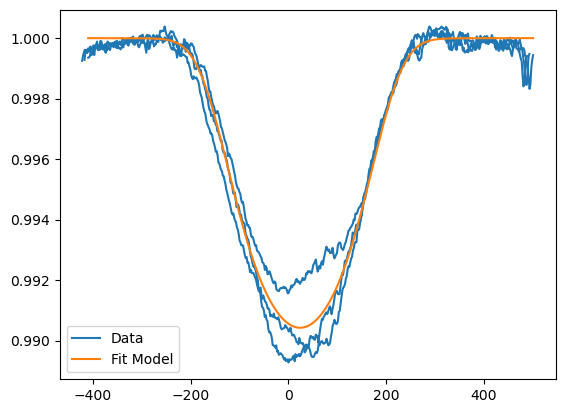

In [36]:
x1=DataPacket.scaled.lsds[0].vel-DataPacket.vrad[0]
y1=DataPacket.scaled.lsds[0].specI
x2=DataPacket.scaled.lsds[1].vel-DataPacket.vrad[1]
y2=DataPacket.scaled.lsds[1].specI
x3=DataPacket.scaled.lsds[2].vel-DataPacket.vrad[2]
y3=DataPacket.scaled.lsds[2].specI

plt.plot(x1,y1,c='C0')
plt.plot(x2,y2,c='C0')
plt.plot(x3,y3,c='C0',label='Data')
plt.plot(x1,modelout,c='C1',label='Fit Model')
plt.legend()

Additionally, we can also perform a fit of kappa and vmac while keeping vsini fixed. This is done by using the `fitdata_novsini` function as done below.

In [18]:

guess=np.array([1.3,30])

parameters,covariance,modelout = rav.fitparams.fitdata_novsini(param,DataPacket,guess)
print(parameters)


[ 0.84514852 95.43467454]


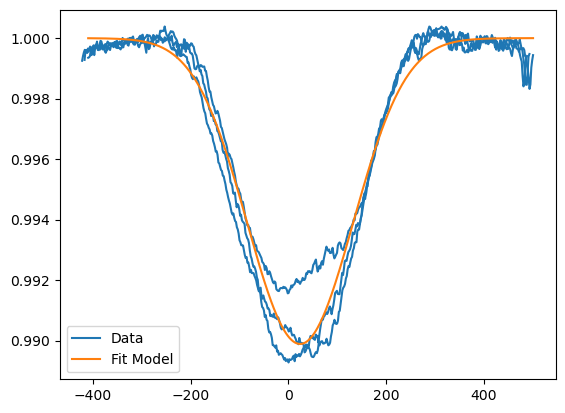

In [13]:
x1=DataPacket.scaled.lsds[0].vel-DataPacket.vrad[0]
y1=DataPacket.scaled.lsds[0].specI
x2=DataPacket.scaled.lsds[1].vel-DataPacket.vrad[1]
y2=DataPacket.scaled.lsds[1].specI
x3=DataPacket.scaled.lsds[2].vel-DataPacket.vrad[2]
y3=DataPacket.scaled.lsds[2].specI

plt.plot(x1,y1,c='C0')
plt.plot(x2,y2,c='C0')
plt.plot(x3,y3,c='C0',label='Data')
plt.plot(x1,modelout,c='C1',label='Fit Model')
plt.legend()

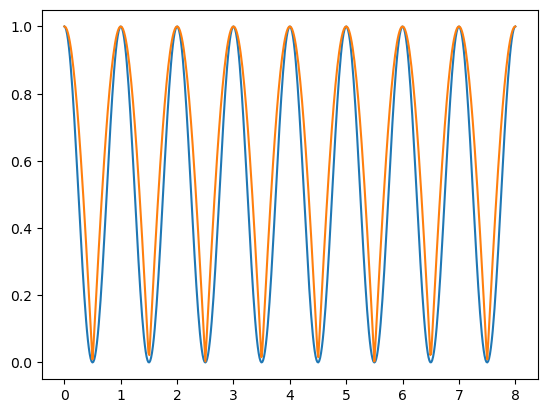

In [21]:
x = np.linspace(0,16*np.pi, 500)

fig, ax = plt.subplots(1,1)
ax.plot(x/(2*np.pi), 0.5*np.sin(x+np.pi/2)+0.5)
ax.plot(x/(2*np.pi), np.abs(np.sin(x/2+np.pi/2)))